
# Solar Cycle Basics Through Simple Time-Series Modeling (Undergraduate Lab)

**Focus:** Build intuition for the solar cycle using simple, controllable time-series models.  
**Why this matters:** Many space measurements (solar wind, IMF, geomagnetic indices) track the solar cycle.

---

## What you will learn
- How to represent a solar cycle as a time series
- How **amplitude modulation**, **cycle overlap**, and **noise** affect observed activity
- How to compute simple diagnostics: smoothing, peak timing, cycle-to-cycle variability
- How to build an activity plot with cycle labels (toy version)



## 0) Setup


In [1]:

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

def nice_plot():
    plt.grid(True, alpha=0.25)
    plt.tight_layout()



## 1) A very simple solar-cycle shape

Real solar cycles are not perfect sine waves.
A common simple representation is:
- an **asymmetric hump** (fast rise, slower decay)
- an **~11-year** timescale (varies in reality)

We will build a cycle template using a skewed function (difference of exponentials).


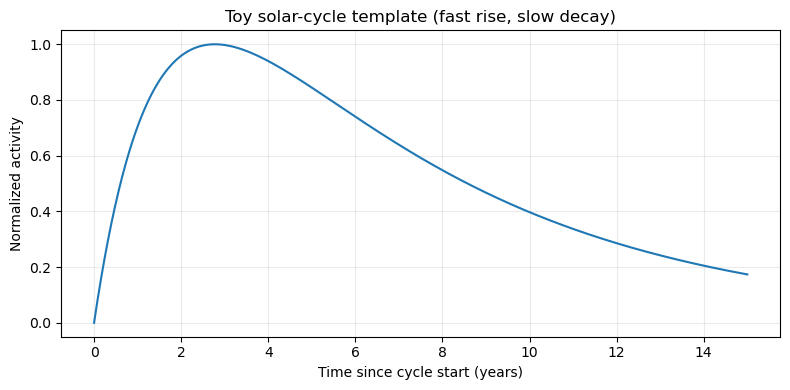

In [2]:

def cycle_template(t, t0=0.0, rise=2.2, decay=5.5):
    """Asymmetric hump starting at t0 (years)."""
    x = np.maximum(t - t0, 0.0)
    # difference of exponentials -> rise then decay
    y = (1 - np.exp(-x / rise)) * np.exp(-x / decay)
    # normalize peak to 1
    y /= (y.max() + 1e-12)
    return y

# Visualize the template
t = np.linspace(0, 15, 1501)
y = cycle_template(t, t0=0.0, rise=2.0, decay=6.0)

plt.figure(figsize=(8,4))
plt.plot(t, y)
plt.xlabel("Time since cycle start (years)")
plt.ylabel("Normalized activity")
plt.title("Toy solar-cycle template (fast rise, slow decay)")
nice_plot()
plt.show()



## 2) Build a multi-cycle activity record

We create an "activity index" A(t) by summing overlapping cycles:
- Each cycle has a start time
- Each cycle has an amplitude (strong/weak cycle)
- Cycles can overlap (late decay of one + early rise of next)

This resembles how many observed indices behave (e.g., sunspot number-like).


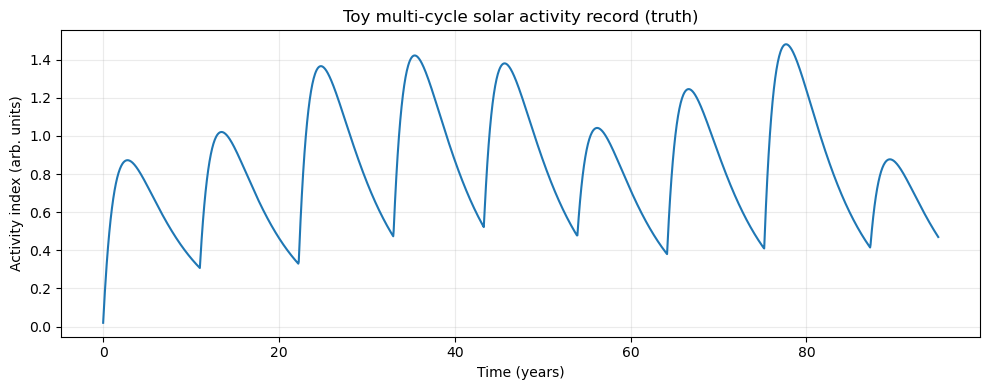

Cycle starts (years): [ 0.   11.   22.24 33.02 43.31 53.94 64.15 75.2  87.27]
Cycle amplitudes: [0.85 0.81 1.15 1.11 1.03 0.72 0.99 1.21 0.6 ]


In [3]:

def generate_cycle_starts(ncycles=8, mean_period=11.0, jitter=0.7, t_start=0.0):
    """Generate start times for cycles with jitter in period."""
    starts = [t_start]
    for _ in range(1, ncycles):
        period = rng.normal(mean_period, jitter)
        starts.append(starts[-1] + max(8.5, period))  # keep realistic lower bound
    return np.array(starts)

def generate_amplitudes(ncycles=8, mean_amp=1.0, amp_sigma=0.25, min_amp=0.4):
    """Generate cycle amplitudes with variability."""
    amps = rng.normal(mean_amp, amp_sigma, size=ncycles)
    return np.clip(amps, min_amp, None)

def build_activity(t, starts, amps, rise=2.2, decay=5.5, baseline=0.0):
    A = np.zeros_like(t) + baseline
    for t0, a in zip(starts, amps):
        A += a * cycle_template(t, t0=t0, rise=rise, decay=decay)
    return A

# Time axis (years)
Tmax = 95
dt = 0.05
t = np.arange(0, Tmax + dt, dt)

starts = generate_cycle_starts(ncycles=9, mean_period=11.0, jitter=0.8, t_start=0.0)
amps   = generate_amplitudes(ncycles=len(starts), mean_amp=1.0, amp_sigma=0.30)

A_true = build_activity(t, starts, amps, rise=2.0, decay=6.0, baseline=0.02)

plt.figure(figsize=(10,4))
plt.plot(t, A_true)
plt.xlabel("Time (years)")
plt.ylabel("Activity index (arb. units)")
plt.title("Toy multi-cycle solar activity record (truth)")
nice_plot()
plt.show()

print("Cycle starts (years):", np.round(starts, 2))
print("Cycle amplitudes:", np.round(amps, 2))



## 3) Add "measurement" realism: noise + smoothing

Real space measurements are noisy and often smoothed (monthly averages, running means).
We simulate:
- **measurement noise**
- a simple **moving average smoothing**


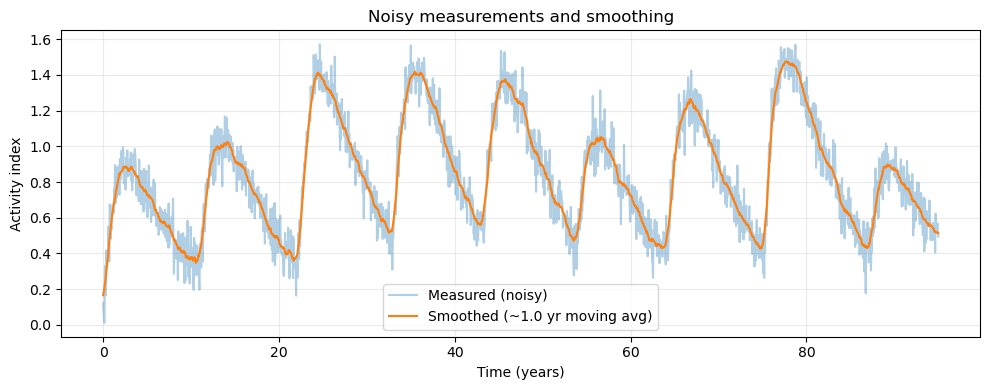

In [12]:

def moving_average(x, window):
    """Centered moving average with output length == len(x), works for odd/even windows."""
    x = np.asarray(x)
    if window <= 1:
        return x.copy()

    w = np.ones(window) / window

    pad_left = window // 2
    pad_right = window - 1 - pad_left   # makes total padding = window-1

    xp = np.pad(x, (pad_left, pad_right), mode="edge")
    y = np.convolve(xp, w, mode="valid")  # length will be len(x)
    return y

noise_sigma = 0.08
A_meas = A_true + rng.normal(0.0, noise_sigma, size=A_true.shape)

# Smooth to mimic monthly/annual averaging
window_years =1.0
window = int(window_years / dt)
A_smooth = moving_average(A_meas, window)

plt.figure(figsize=(10,4))
plt.plot(t, A_meas, alpha=0.35, label="Measured (noisy)")
plt.plot(t, A_smooth, label=f"Smoothed (~{window_years:.1f} yr moving avg)")
plt.xlabel("Time (years)")
plt.ylabel("Activity index")
plt.title("Noisy measurements and smoothing")
plt.legend()
nice_plot()
plt.show()



## 4) Identify cycles: peak times and strengths (simple approach)

We estimate cycle peaks by finding local maxima in the smoothed series.
This is a teaching approach (not a production method).


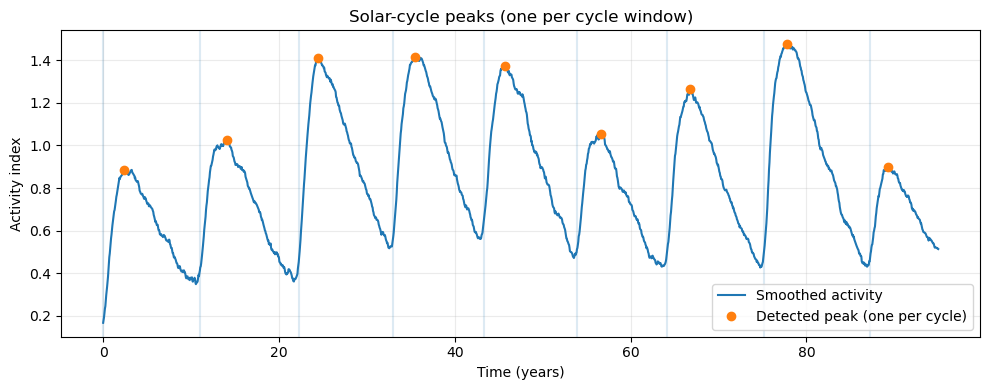

Detected peak times (years): [ 2.4  14.1  24.45 35.45 45.75 56.6  66.8  77.75 89.25]
Detected peak values: [0.89 1.02 1.41 1.42 1.37 1.05 1.26 1.48 0.9 ]


In [13]:
# --- Peak detection: one peak per cycle using known cycle start times ---

peak_idx = []

# Define the search window for each cycle:
# from start of cycle i to start of cycle i+1 (or to end of data for the last cycle)
for i in range(len(starts)):
    t0 = starts[i]
    t1 = starts[i+1] if i < len(starts) - 1 else t[-1] + 1e-9

    # indices of samples within this cycle window
    mask = (t >= t0) & (t < t1)
    if not np.any(mask):
        continue

    # pick the maximum within the window
    j_local = np.nanargmax(A_smooth[mask])
    idx_window = np.where(mask)[0]
    peak_idx.append(idx_window[j_local])

peak_idx = np.array(peak_idx, dtype=int)

# Optional: keep only "prominent" cycles (useful if you simulate very weak cycles)
threshold = 0.35 * np.nanmax(A_smooth)
peak_idx = peak_idx[A_smooth[peak_idx] > threshold]

peak_times = t[peak_idx]
peak_vals  = A_smooth[peak_idx]

# Plot
plt.figure(figsize=(10,4))
plt.plot(t, A_smooth, label="Smoothed activity")
plt.plot(peak_times, peak_vals, "o", label="Detected peak (one per cycle)")
for i, t0 in enumerate(starts):
    plt.axvline(t0, alpha=0.15)
plt.xlabel("Time (years)")
plt.ylabel("Activity index")
plt.title("Solar-cycle peaks (one per cycle window)")
plt.legend()
nice_plot()
plt.show()

print("Detected peak times (years):", np.round(peak_times, 2))
print("Detected peak values:", np.round(peak_vals, 2))



## 5) Cycle-to-cycle variability: amplitude modulation

Cycle amplitudes vary. Here you can control that variability and see how the record changes.

**Exercise:** Increase `amp_sigma` (e.g., 0.15 → 0.45) and compare.


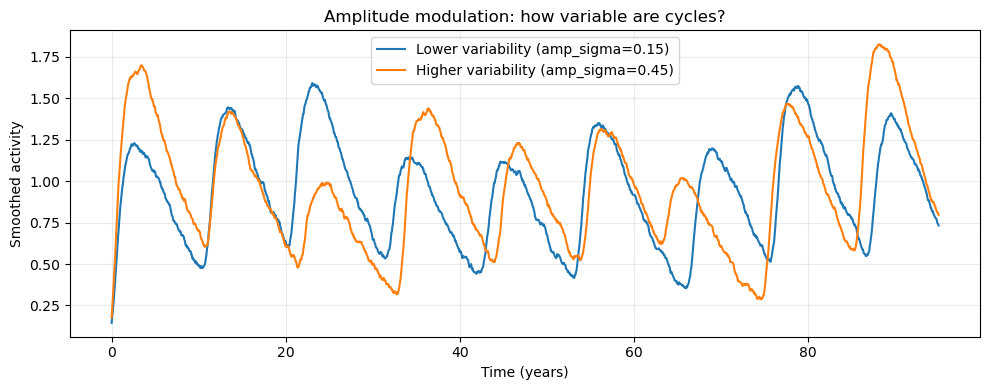

In [14]:

def simulate_activity_record(
    Tmax=95, dt=0.05,
    ncycles=9, mean_period=11.0, period_jitter=0.8,
    mean_amp=1.0, amp_sigma=0.30,
    rise=2.0, decay=6.0,
    noise_sigma=0.08, smooth_years=1.0
):
    t = np.arange(0, Tmax + dt, dt)
    starts = generate_cycle_starts(ncycles=ncycles, mean_period=mean_period, jitter=period_jitter, t_start=0.0)
    amps   = generate_amplitudes(ncycles=len(starts), mean_amp=mean_amp, amp_sigma=amp_sigma)

    A_true = build_activity(t, starts, amps, rise=rise, decay=decay, baseline=0.02)
    A_meas = A_true + rng.normal(0.0, noise_sigma, size=A_true.shape)
    window = max(1, int(smooth_years / dt))
    A_smooth = moving_average(A_meas, window)

    return t, starts, amps, A_true, A_meas, A_smooth

# Compare two variability levels
t1, starts1, amps1, _, _, smooth1 = simulate_activity_record(amp_sigma=0.15)
t2, starts2, amps2, _, _, smooth2 = simulate_activity_record(amp_sigma=0.45)

plt.figure(figsize=(10,4))
plt.plot(t1, smooth1, label="Lower variability (amp_sigma=0.15)")
plt.plot(t2, smooth2, label="Higher variability (amp_sigma=0.45)")
plt.xlabel("Time (years)")
plt.ylabel("Smoothed activity")
plt.title("Amplitude modulation: how variable are cycles?")
plt.legend()
nice_plot()
plt.show()



## 6) Cycle overlap: why minima are not perfectly flat

Because cycles decay slowly, the next cycle can start rising before the previous is gone.
This creates overlap and makes minima less “quiet”.

**Exercise:** Change `decay` (e.g., 4 → 8 years) and compare how overlap increases.


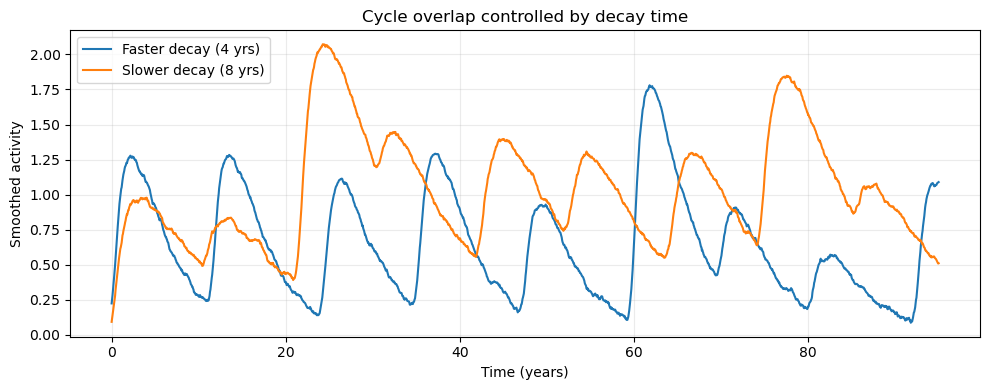

In [15]:

tA, _, _, _, _, smooth_fast_decay = simulate_activity_record(decay=4.0)
tB, _, _, _, _, smooth_slow_decay = simulate_activity_record(decay=8.0)

plt.figure(figsize=(10,4))
plt.plot(tA, smooth_fast_decay, label="Faster decay (4 yrs)")
plt.plot(tB, smooth_slow_decay, label="Slower decay (8 yrs)")
plt.xlabel("Time (years)")
plt.ylabel("Smoothed activity")
plt.title("Cycle overlap controlled by decay time")
plt.legend()
nice_plot()
plt.show()



## 7) Make a “cycle-labeled” activity plot (toy version)

We will label cycles using the generated start times.
In real datasets, official cycle numbering comes from historical minima; here we show the *concept*.

**Tip for teaching:** Ask students to point at:
- rising phase, maximum, declining phase, minimum


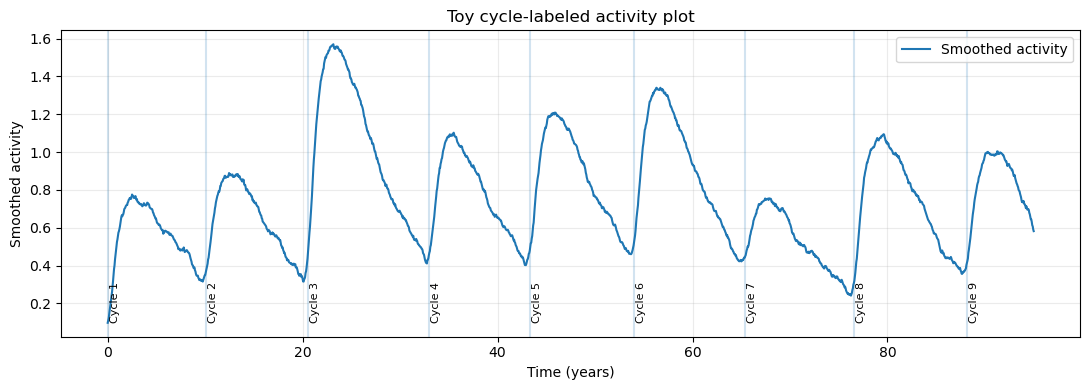

In [16]:

# Build one record to label
t, starts, amps, A_true, A_meas, A_smooth = simulate_activity_record(amp_sigma=0.30, decay=6.0)

plt.figure(figsize=(11,4))
plt.plot(t, A_smooth, label="Smoothed activity")
for i, t0 in enumerate(starts):
    plt.axvline(t0, alpha=0.2)
    # label near the start line
    plt.text(t0 + 0.2, np.nanmax(A_smooth)*0.06, f"Cycle {i+1}", rotation=90, fontsize=8, va="bottom")

plt.xlabel("Time (years)")
plt.ylabel("Smoothed activity")
plt.title("Toy cycle-labeled activity plot")
plt.legend()
nice_plot()
plt.show()



## 8) Mini-project (20–30 minutes): build your own scenario

Choose ONE:

### Option A: A “grand minimum”
- Set a few consecutive amplitudes to very low values (e.g., 0.4).
- Interpret what a spacecraft would see during that time.

### Option B: Period change trend
- Make mean_period slowly increase or decrease with time.
- Discuss how this would change cycle timing and overlap.

### Option C: Measurement vs reality
- Compare A_true vs A_meas vs A_smooth.
- Decide which one you would trust for estimating cycle amplitude.

**Deliverable:** One figure + 3 bullet points explaining your conclusion.


In [ ]:

# Option A example: impose a grand minimum by modifying amplitudes
t, starts, amps, A_true, A_meas, A_smooth = simulate_activity_record(ncycles=9, amp_sigma=0.30, decay=6.0)

# Force cycles 4-5 to be weak
amps_mod = amps.copy()
if len(amps_mod) >= 6:
    amps_mod[3] = 0.45
    amps_mod[4] = 0.40

A_true_mod = build_activity(t, starts, amps_mod, rise=2.0, decay=6.0, baseline=0.02)
A_meas_mod = A_true_mod + rng.normal(0.0, 0.08, size=A_true_mod.shape)
A_smooth_mod = moving_average(A_meas_mod, max(1, int(1.0/dt)))

plt.figure(figsize=(11,4))
plt.plot(t, A_smooth, label="Original scenario")
plt.plot(t, A_smooth_mod, label="With a grand minimum (cycles 4–5 weaker)")
plt.xlabel("Time (years)")
plt.ylabel("Smoothed activity")
plt.title("Example mini-project: grand minimum scenario")
plt.legend()
nice_plot()
plt.show()

print("Original amps:", np.round(amps, 2))
print("Modified amps:", np.round(amps_mod, 2))



## 9) Wrap-up (key takeaways)

- Solar activity is **cyclic** but not perfectly periodic.
- Cycles vary in **amplitude** and **timing**, and often **overlap**.
- Measurements are noisy; smoothing helps reveal the cycle but can hide short-term behavior.
- Simple models help you interpret what you see in spacecraft time series and what might be hidden.
